## Library loading

In [60]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np 
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D,  Reshape, UpSampling2D, Dense, Flatten, Conv2D, ReLU, Conv2DTranspose, LeakyReLU, Layer, ZeroPadding2D
from tensorflow.keras.activations import tanh
import time
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import collections
import time
 
print(tf.__version__)
tf.enable_eager_execution()

1.12.0


## Util functions

In [80]:
def TFrecord_generator(output_folder, tfrecord_name, x_train):
    ''' TFrecords generation at different image sizes '''
    
    img_size = x_train.shape[1]
    size_range = np.arange(2, np.log2(img_size) + 1)
    tf_record_pre_fix = 'PGGAN'
    filename_list = []

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for size in size_range:
        tf_record_name = '{}_{}x{}'.format(tfrecord_name, str(int(2**size)),str(int(2**size)))
        filename = os.path.join(output_folder, tf_record_pre_fix + '_{}.tfrecords'.format(tf_record_name))
        filename_list.append(filename)
        writer = tf.python_io.TFRecordWriter(filename)

        for image in tqdm(x_train):
            image = tf.image.resize_images(image, [int(2**size), int(2**size)])
            image = (image - 127.5) / 127.5
            image = np.array(image)
            image_raw = image.tostring()
            example = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(image_raw)
            }))
            writer.write(example.SerializeToString())
        writer.close()
        print("{} generation finished".format(filename))
    return filename_list 

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def Dataset_generator(tfrecord_path, batch_size):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(lambda x:_read_from_tfrecord(x)).repeat()
    dataset = dataset.shuffle(buffer_size=(int(50000) * 2 + 3 * batch_size))
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    return iterator

def _read_from_tfrecord(example_proto):
    tfrecord_features = tf.parse_single_example(example_proto,
                                                features={
                                                    'image_raw': tf.FixedLenFeature([], tf.string)
                                                }, name='features')
    image = tf.decode_raw(tfrecord_features['image_raw'], tf.float32)
    return image


def fake_image_gp_generator(input_image, fake_image):
    ''' fake image generator for WGAN-GP loss'''
    
    batch_size = input_image.shape[0]
    epsilon = tf.random.uniform([batch_size])
    input_image = np.array(input_image) # convert to numpy array for multiplying epsilon with input image
    for i in range(batch_size):      
      input_image[i] = epsilon[i] * input_image[i]
    return tf.cast(input_image, tf.float32)

def generate_and_save_images(model, test_input):
    ''' image save & display for every period interval'''
    
    predictions = model(test_input, alpha, transition = False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


class BatchNormalization_N(tf.keras.layers.Layer):
    ''' Batch-Normalization layer'''
    
    def __init__(self, epsilon=1e-5):
        super(BatchNormalization_N, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
       shape = tf.TensorShape(input_shape)
       param_shape = shape[-1]
       self.gamma = self.add_weight(name='gamma',
                                shape=param_shape,
                                initializer='ones',
                                trainable=True)
       self.beta = self.add_weight(name='beta',
                               shape=param_shape,
                               initializer='zeros',
                               trainable=True)
    
    def call(self, inputs):
       input_shape = inputs.get_shape()
       reduction_axes = [1, 2, 3] 
       mean, variance = tf.nn.moments(inputs, reduction_axes, keep_dims=True)
       normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
       return self.gamma * normalized + self.beta


class LRNormalization(tf.keras.layers.Layer):
    ''' Local Response Normalization layer'''
    
    def __init__(self, epsilon=1e-8):
        super(LRNormalization, self).__init__()
        self.epsilon = epsilon

    def call(self, inputs):
       input_shape = inputs.get_shape()
       n_feature_maps = input_shape[-1]
       x = inputs / tf.expand_dims(tf.sqrt((1/int(n_feature_maps))*tf.reduce_sum(tf.math.square(inputs), axis=-1) + self.epsilon),axis=-1)
       return x 


class from_rgb(tf.keras.Model):
    ''' from rgb layer'''
    
    def __init__(self, filters):
      super(from_rgb, self).__init__()
      self.from_rgb = Conv2D(filters, 1, padding='same', name = 'from_rgb_layer')        
      self.activation =  LeakyReLU()
  
    def call(self, x):
      x = self.from_rgb(x)
      x = self.activation(x)
      return x 
    
class to_rgb(tf.keras.Model):
    ''' to rgb layer'''
    
    def __init__(self):
      super(to_rgb, self).__init__()
      self.to_rgb = Conv2D(3, 1, padding='same', name = 'to_rgb_layer')
        
    def call(self, x):
      x = self.to_rgb(x)
      return x 

## Generator blocks

In [71]:
class G_block_init(tf.keras.Model):  
  ''' Generator initial block '''

  def __init__(self, filters, initial_size, block_num):
    super(G_block_init, self).__init__()
    self.dense = Dense(units = filters*initial_size*initial_size, name = 'g' + str(block_num) + '_dense_1')
    self.activation =  LeakyReLU()
    self.reshape = Reshape((initial_size,initial_size,filters))   
    self.conv1 = Conv2D(filters, 3, padding='same', name = 'g' + str(block_num) + '_conv_1')
    self.ln = LRNormalization()

  def call(self, latents):
    x = self.dense(latents)
    x = self.activation(x)
    x = self.reshape(x)
    x = self.conv1(x)
    x = self.ln(x)
    x = self.activation(x)

    return x
 
class G_block_mid(tf.keras.Model):
  ''' Generator mid block '''

  def __init__(self, filters, block_num):
    super(G_block_mid, self).__init__()
    self.upsample = UpSampling2D(name = 'g' + str(block_num) + '_upsampling')
    self.conv1 = Conv2D(filters, 3, padding='same',name = 'g' + str(block_num)  + '_conv_1')
    self.conv2 = Conv2D(filters, 3, padding='same',name = 'g' + str(block_num)  + '_conv_2')  
    self.ln = LRNormalization()
    self.activation =  LeakyReLU()
  
  def call(self, x):
    x = self.upsample(x)
    x = self.conv1(x)
    x = self.ln(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.ln(x)
    x = self.activation(x)
    return x



## Discriminator blocks

In [72]:
class D_block_mid(tf.keras.Model):  
  ''' Discriminator mid block '''

  def __init__(self, filter1,filter2, block_num):
    super(D_block_mid, self).__init__()
    self.conv1 = Conv2D(filter1, 3, padding='same', name = 'd' + str(block_num)  + '_conv_1')
    self.conv2 = Conv2D(filter2, 3, padding='same', name = 'd' + str(block_num)  + '_conv_2')
    self.downsampling =  AveragePooling2D(name = 'd' + str(block_num) + '_downsampling')
    self.activation =  LeakyReLU()
    
  def call(self, x): 
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    x = self.downsampling(x)

    return x

class D_block_last(tf.keras.Model):  
  ''' Discriminator initial block '''

  def __init__(self, filters, block_num):
    super(D_block_last, self).__init__()
    self.conv1 = Conv2D(filters, 3, padding='same',name = 'd' + str(block_num)  + '_conv_1')
    self.conv2 = Conv2D(filters, 4, padding='same',name = 'd' + str(block_num)  + '_conv_2')
    self.flatten = Flatten()
    self.dense = Dense(1,  name = 'd' + str(block_num) + '_dense_1')
    self.activation =  LeakyReLU()
    self.bn1 = BatchNormalization_N()
    self.bn2 = BatchNormalization_N()
    
  def call(self, x):
    x = self.conv1(x)
#     x = self.bn1(x)
    x = self.activation(x)
    x = self.conv2(x)
#     x = self.bn2(x)
    x = self.activation(x)
    x = self.flatten(x)
    x = self.dense(x)
    return x


## Model building

In [73]:
class Building_generator(tf.keras.Model):
    ''' Generator building'''

    def __init__(self):     
      super(Building_generator, self).__init__()
      self.upsampling = UpSampling2D()
      self.up = False
    
    def call(self, x, alpha, transition=False):
      generator_blocks = [var for var in dir(self) if 'generator_block' in var]

      if transition == False:
        for block in generator_blocks: 
            x = vars(self)[block](x)
        x = self.to_rgb_layer(x)

      else:        
        for idx,block in enumerate(generator_blocks):  # 만약 block이 2개 일경우, len(block) ==2, 
            x = vars(self)[block](x) #  4 x 4  -> 8 x8 

            if idx == len(generator_blocks)-2:      
                self.up = True
                up_x = self.upsampling(x)   # 4 x 4 -> 8 x8                        
        x = self.to_rgb_layer(x)            
        
        if self.up == True:
            up_x = self.to_rgb_layer_up(up_x)
            x = (1-alpha)*up_x + alpha*x
            x = tf.clip_by_value(x, 0.0, 1.0)
        self.up = False
        
      return x


class Building_discriminator(tf.keras.Model):
    ''' Discriminator building'''

    def __init__(self):     
      super(Building_discriminator, self).__init__()
      self.downsampling = AveragePooling2D()
    
    def call(self, x, filters, alpha, transition=False):
      discriminator_blocks = [var for var in dir(self) if 'discriminator_block' in var]
      discriminator_blocks.reverse()    

      if transition == False:
        x = self.from_rgb_layer(x)
        for block in discriminator_blocks:
            x = vars(self)[block](x)          
      else:
        x = self.from_rgb_layer(x)
        down_x = self.downsampling(x)
        down_x = self.from_rgb_layer_down(down_x)    # down의 필터수는 x의 필터수의 2배가 되어야 함 (x기준으로 합쳐짐) 
        
        for idx, block in enumerate(discriminator_blocks):
            x = vars(self)[block](x)      
            if (idx == 0) & (len(discriminator_blocks)>1) :            # 처음에 이미지 downsampling 할때만 수행, 하지만 4x4 받을 경우는 예외
                x = (1-alpha)*down_x + alpha*x
                x = tf.clip_by_value(x, 0.0, 1.0)
      return x


## Loss

In [74]:
def adverserial_loss(logits):
  loss = tf.reduce_mean(logits)
  return loss

def gradient_penalty(gp_D_src_grad):
    l2_norm = tf.sqrt(tf.reduce_sum(gp_D_src_grad**2))
    return (l2_norm-1)**2
    
def G_loss(fake_D_prob):
  loss = -adverserial_loss(fake_D_prob) 
  return loss
  
def D_loss(real_D_prob, fake_D_prob, gp_D_prob_grad):
  loss = -adverserial_loss(real_D_prob) + adverserial_loss(fake_D_prob)  + lambda_gp*gradient_penalty(gp_D_prob_grad) 
  return loss

## Optimizer

In [75]:
generator_optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1 = 0.9, beta2 = 0.99, epsilon = 1e-8)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1 = 0.9, beta2 = 0.99, epsilon = 1e-8)

## Data download

In [41]:
from tensorflow.keras.datasets.cifar10 import load_data
(x_train, _) , (x_test, _) = load_data()
# x_train = x_train[:1000]

## TFrecords generation

In [42]:
training_batch_schedule = {4:128, 8:64, 16:32, 32:32} 
tfrecord_folder = '/home/Markkim/PGGAN/Implementation/'
tfrecord_list = TFrecord_generator('/home/Markkim/PGGAN/Implementation/', '20190521', x_train)
iterator_dict = {}
size = 4

for tfrecord in tfrecord_list:
    dataset_name = tfrecord.split('/')[-1].split('.')[0]
    iterator_dict[size] = dataset_name
    batch_size = training_batch_schedule[size]
    globals()[dataset_name] = Dataset_generator(tfrecord, batch_size)
    size = size * 2

  0%|          | 58/50000 [00:00<01:28, 566.26it/s]

/home/Markkim/PGGAN/Implementation/PGGAN_20190521_4x4.tfrecords generation finished


  0%|          | 19/50000 [00:00<04:28, 186.17it/s]

/home/Markkim/PGGAN/Implementation/PGGAN_20190521_8x8.tfrecords generation finished


  0%|          | 94/50000 [00:00<00:53, 933.40it/s]

/home/Markkim/PGGAN/Implementation/PGGAN_20190521_16x16.tfrecords generation finished


100%|██████████| 50000/50000 [00:59<00:00, 838.14it/s] 

/home/Markkim/PGGAN/Implementation/PGGAN_20190521_32x32.tfrecords generation finished


## Modeling building

In [81]:
discriminator = Building_discriminator()
generator = Building_generator()

## Training

Resolution 4x4 training started. Total steps are 3906
Size 4 x 4 Transition Mode: False, Step 0 [D loss: 1.485722] [Time: 0.285261 s]
Size 4 x 4 Transition Mode: False, Step 0 [G loss: -0.062563] [Time: 0.285261 s]


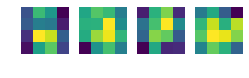

Size 4 x 4 Transition Mode: False, Step 488 [D loss: -0.199054] [Time: 0.116289 s]
Size 4 x 4 Transition Mode: False, Step 488 [G loss: -0.044800] [Time: 0.116289 s]


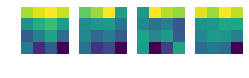

Size 4 x 4 Transition Mode: False, Step 976 [D loss: 0.132635] [Time: 0.209631 s]
Size 4 x 4 Transition Mode: False, Step 976 [G loss: 2.580977] [Time: 0.209631 s]


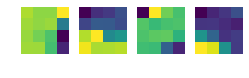

Size 4 x 4 Transition Mode: False, Step 1464 [D loss: 0.076061] [Time: 0.088804 s]
Size 4 x 4 Transition Mode: False, Step 1464 [G loss: 0.156795] [Time: 0.088804 s]


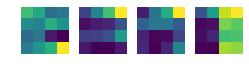

In [ ]:
# hyper-paramters
filter_dict = {4:256, 8:256, 16:256, 32:128} # image size : filters
training_filters_schedule = collections.OrderedDict(sorted(filter_dict.items()))
training_epoch_schedule = {4:10, 8:10, 16:10, 32:10} # image size : epochs
training_batch_schedule = {4:128, 8:64, 16:64, 32:32} # image size : batch
init_filters = training_filters_schedule[4]
lambda_gp = 10
n_img = 50000
# time_s = time.time()
    
for block_num, resolution in enumerate(list(training_filters_schedule.keys())):
    
    #iterator setup
    iterator = eval(iterator_dict[resolution])    
    
    # tota training steps for each resolution
    total_steps = int((training_epoch_schedule[resolution] * n_img) // training_batch_schedule[resolution])
    
    # training steps for the transition phase mode
    transition_end_steps = int(total_steps // 2)
    
    # feature map size for each resolution
    filters = training_filters_schedule[resolution]   
    
    # batch size for each resolution
    batch_size = training_batch_schedule[resolution]
    
    # print & display interval
    print_period =  int(total_steps // 8)
    print_generate = int(total_steps // 8)
        
    # Generator building for each resolution
    if block_num == 0:
        setattr(generator, 'generator_block_'+ str(block_num), G_block_init(filters, resolution, block_num))
    else:
        setattr(generator, 'generator_block_'+ str(block_num), G_block_mid(filters, block_num))
    setattr(generator, 'to_rgb_layer', to_rgb())
    setattr(generator, 'to_rgb_layer_up', to_rgb())
    
    # Discriminator building for each resolution 
    setattr(discriminator, 'from_rgb_layer', from_rgb(filters))
    setattr(discriminator, 'from_rgb_layer_down', from_rgb(min(filters*2, 512)))

    if block_num == 0:    
        setattr(discriminator, 'discriminator_block_'+ str(block_num), D_block_last(filters, block_num))
    else:
        setattr(discriminator, 'discriminator_block_'+ str(block_num), D_block_mid(filters, min(filters*2, 512), block_num))

    #training start
    print('Resolution {}x{} training started. Total steps are {}'.format(resolution, resolution, total_steps))
    for step in range(total_steps): # total steps for per each resolution

        time_s = time.time()

        # loss calculation    
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:        
            latents = tf.random_normal((batch_size, 1,1,init_filters))            

            # transition conditions
            if (step >= transition_end_steps) | (block_num == 0):
                transition = False
                alpha = None

            else:
                transition = True
                alpha = float(step/(total_steps - transition_end_steps)) 

            # loss calculation    
            fake_image = generator(latents, alpha, transition = transition)
            fake_D_prob = discriminator(fake_image, filters, alpha, transition = transition)        
 
            input_image = iterator.get_next()
            input_image = tf.reshape(input_image, shape=(-1, resolution, resolution, 3))
            real_D_prob = discriminator(input_image, filters, alpha, transition = transition)

            with tf.GradientTape() as gp_tape:   
              fake_image_gp = fake_image_gp_generator(input_image, fake_image) 
              gp_tape.watch(fake_image_gp)
              gp_D_prob  = discriminator(fake_image_gp, filters, alpha, transition = transition)

            gp_D_prob_grad = gp_tape.gradient(gp_D_prob, fake_image_gp)  
            discriminator_loss = D_loss(real_D_prob, fake_D_prob, gp_D_prob_grad) 
            generator_loss = G_loss(fake_D_prob)

        # gradient updates
        gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        if (step % print_period == 0) & (transition == True):
                time_lapsed = time.time() - time_s
                print ("Size %d x %d, Transition Mode: %s, Alpha: %f, Step %d [D loss: %f], [Time: %f s]" % (resolution, resolution, transition, alpha, step, discriminator_loss, time_lapsed))   
                print ("Size %d x %d, Transition Mode: %s, Alpha: %f, Step %d [G loss: %f], [Time: %f s]" % (resolution, resolution, transition, alpha, step, generator_loss, time_lapsed))   
 
        elif (step % print_period == 0) & (transition == False):
                time_lapsed = time.time() - time_s
                print ("Size %d x %d Transition Mode: %s, Step %d [D loss: %f] [Time: %f s]" % (resolution, resolution, transition, step,discriminator_loss, time_lapsed))   
                print ("Size %d x %d Transition Mode: %s, Step %d [G loss: %f] [Time: %f s]" % (resolution, resolution, transition, step,generator_loss, time_lapsed))            

        if step % print_generate == 0:
            test_input = tf.random_normal((4, 1,1,init_filters))   
            generate_and_save_images(generator, test_input)


In [33]:
for var in discriminator.trainable_variables:
    print(var)

<tf.Variable 'building_discriminator_5/from_rgb_42/from_rgb_layer/kernel:0' shape=(1, 1, 3, 256) dtype=float32, numpy=
array([[[[ 5.58095686e-02,  4.99329790e-02, -6.57194108e-02,
          -1.13490865e-01, -3.99806648e-02,  6.16130680e-02,
           4.16751532e-03, -1.19598471e-01,  1.31086797e-01,
           1.03751056e-01, -1.26610603e-02,  9.89221856e-02,
           5.25911823e-02, -6.74470812e-02, -7.42032984e-03,
           6.75729886e-02, -1.20436989e-01, -7.76951164e-02,
           3.46397236e-02, -6.84547424e-02,  4.03349614e-03,
          -8.77683312e-02,  3.88352200e-03,  4.62325588e-02,
           8.51267427e-02, -4.21595424e-02,  3.54885049e-02,
          -8.25288966e-02, -3.66070680e-02,  1.20900407e-01,
          -7.01974109e-02,  1.27704870e-02, -3.03992275e-02,
          -1.12427011e-01,  7.68930167e-02, -4.42384407e-02,
           2.75003146e-02, -1.01733923e-01, -4.99171093e-02,
          -5.14630340e-02,  6.79276958e-02,  2.12433301e-02,
          -4.17955071e-02, 

In [34]:
Image.fromarray(np.array(input_image[0,:,:,:]))

TypeError: Cannot handle this data type

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


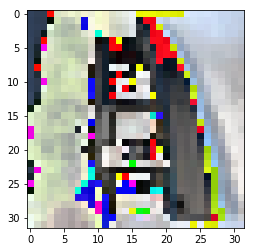

In [35]:
import matplotlib.pyplot as plt
from scipy.misc import toimage
plt.imshow(toimage(np.transpose(np.array(input_image[3, :, :, :]*0.5+ 0.5), (1,2,0))))

In [ ]:
img.shape

In [ ]:
img.shape

In [ ]:
x_train[0]

In [ ]:
x_train[1].shape

In [ ]:
fig = plt.figure(figsize=(2,2))
single_img_reshaped = x_train[1]
plt.imshow(single_img_reshaped)

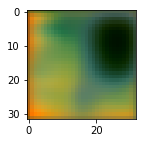

In [36]:
fig = plt.figure(figsize=(2,2))
img = np.array(generator(tf.random_normal((batch_size, 1,1,init_filters)), alpha = None)[0])
img = img/img.max()
plt.imshow(img)

In [ ]:
img = np.array(generator(tf.random_normal((batch_size, 1,1,init_filters)), alpha = None)[0])
fig = plt.figure(figsize=(5,5))
# plt.imshow(np.transpose(input_image[0, :, :, :] * 0.5 + 0.5, (1, 2, 0))
# plt.imshow(np.array(input_image[0, :, :, :]).T * 0.5 + 0.5)
plt.imshow(img, interpolation='nearest')
# plt.imshow(np.transpose(img, (1, 2, 0)) + 0.5)

In [57]:
print(test_input.max(), test_input.min())

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'max'

In [ ]:
def generate_and_save_images(model, test_input):
  predictions = model(test_input, alpha, transition = False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
#       plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5)
      plt.axis('off')
  plt.show()

img = generator(tf.random_normal((batch_size, 1,1,init_filters)), alpha = None)


In [ ]:
for i in range(len(gradients_of_discriminator)):
    if gradients_of_discriminator[i] == None:
        pass
    else:
        print(tf.reduce_max(gradients_of_discriminator[i]),gradients_of_discriminator[i].shape) 

In [55]:
for var in generator.trainable_variables:
    if 'bias' not in var.name:
        print(var.name)

building_generator_2/g_block_init_7/g0_dense_1/kernel:0
building_generator_2/g_block_init_7/g0_conv_1/kernel:0
building_generator_2/g_block_init_7/batch_normalization_n_25/gamma:0
building_generator_2/g_block_init_7/batch_normalization_n_25/beta:0
building_generator_2/to_rgb_16/to_rgb_layer/kernel:0
building_generator_2/g_block_mid_1/g1_conv_1/kernel:0
building_generator_2/g_block_mid_1/g1_conv_2/kernel:0
building_generator_2/g_block_mid_1/batch_normalization_n_28/gamma:0
building_generator_2/g_block_mid_1/batch_normalization_n_28/beta:0
building_generator_2/g_block_mid_1/batch_normalization_n_29/gamma:0
building_generator_2/g_block_mid_1/batch_normalization_n_29/beta:0
building_generator_2/to_rgb_18/to_rgb_layer/kernel:0
building_generator_2/to_rgb_19/to_rgb_layer/kernel:0


In [ ]:
# discriminator.trainable_variables.reverse()
for var in discriminator.trainable_variables:
     if 'bias' not in var.name:
        print(var.name)

In [ ]:
discriminator.trainable_variables